# 🤖 Sahte Haber Tespiti - Basit Model Eğitimi

Bu notebook'ta temel kütüphanelerle sahte haber tespit modeli eğiteceğiz.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
print("✅ Kütüphaneler yüklendi!")

✅ Kütüphaneler yüklendi!


In [2]:
# Veri yükleme
print("📁 Veri yükleniyor...")

fake_news = pd.read_csv('../data/Fake.csv')
real_news = pd.read_csv('../data/True.csv')

# Etiketleme
fake_news['label'] = 0  # Sahte
real_news['label'] = 1  # Gerçek

# Birleştirme
df = pd.concat([fake_news, real_news], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Temizleme
df = df.dropna(subset=['title', 'text'])
df['combined_text'] = df['title'] + ' ' + df['text']

print(f"✅ Veri hazır: {len(df):,} haber")
print(f"📊 Sahte: {len(df[df['label'] == 0]):,}")
print(f"📊 Gerçek: {len(df[df['label'] == 1]):,}")

📁 Veri yükleniyor...


✅ Veri hazır: 44,898 haber
📊 Sahte: 23,481
📊 Gerçek: 21,417


In [3]:
# Veri setini böl
X = df['combined_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"🔄 Eğitim seti: {len(X_train):,} örnek")
print(f"🔄 Test seti: {len(X_test):,} örnek")

# TF-IDF
print("\n🔤 TF-IDF vektörizasyon...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', lowercase=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ {X_train_tfidf.shape[1]} özellik oluşturuldu")

🔄 Eğitim seti: 35,918 örnek
🔄 Test seti: 8,980 örnek

🔤 TF-IDF vektörizasyon...


✅ 5000 özellik oluşturuldu


In [4]:
# Model eğitimi
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB()
}

results = {}

print("🤖 Modeller eğitiliyor...")

for name, model in models.items():
    print(f"\n🔄 {name} eğitiliyor...")
    
    # Eğitim
    model.fit(X_train_tfidf, y_train)
    
    # Tahmin
    y_pred = model.predict(X_test_tfidf)
    
    # Sonuçları kaydet
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"✅ {name} Doğruluk: {accuracy:.4f}")

print("\n🎯 Model eğitimi tamamlandı!")

🤖 Modeller eğitiliyor...

🔄 Logistic Regression eğitiliyor...


✅ Logistic Regression Doğruluk: 0.9870

🔄 Random Forest eğitiliyor...


✅ Random Forest Doğruluk: 0.9981

🔄 Naive Bayes eğitiliyor...
✅ Naive Bayes Doğruluk: 0.9373

🎯 Model eğitimi tamamlandı!


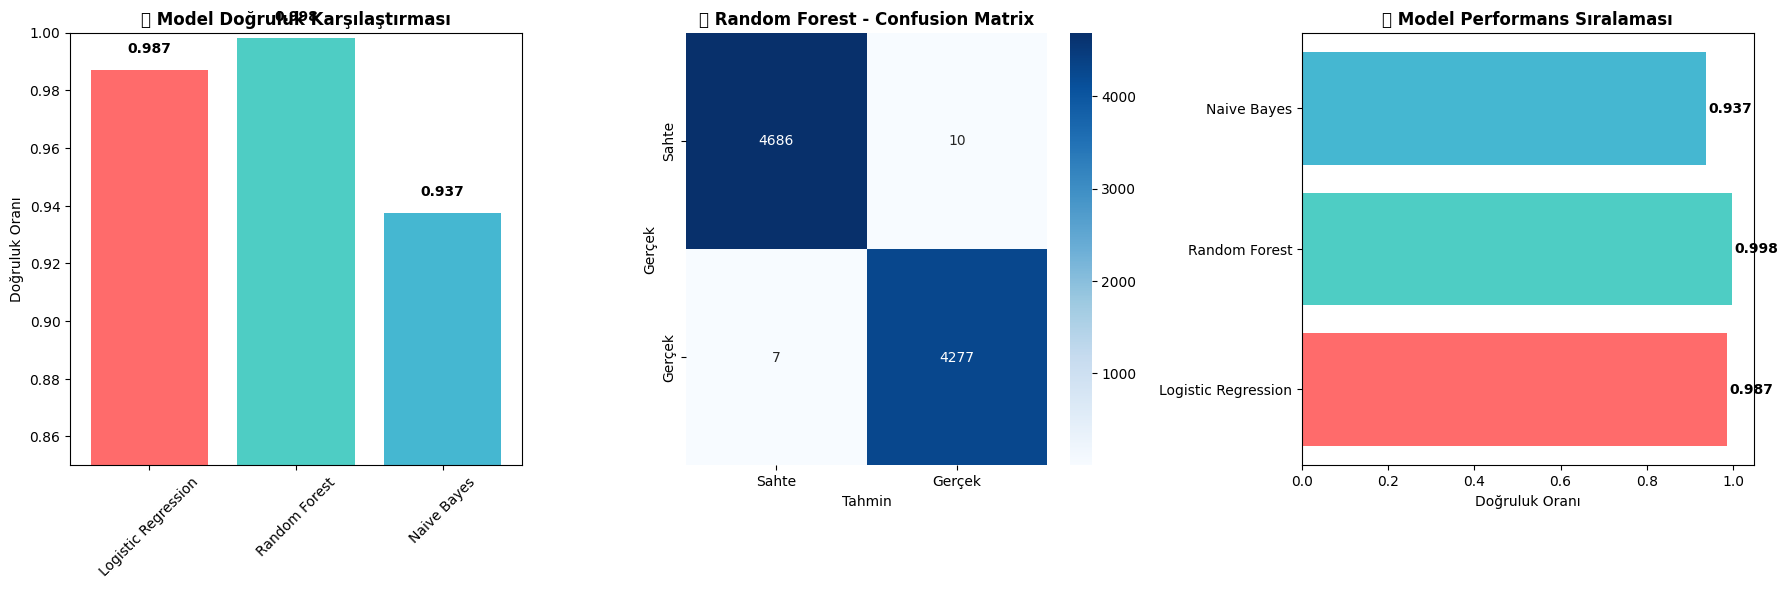


🏆 En iyi model: Random Forest (Doğruluk: 0.9981)


In [5]:
# Model performans görselleştirmesi
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Doğruluk karşılaştırması
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

bars = axes[0].bar(model_names, accuracies, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[0].set_title('🎯 Model Doğruluk Karşılaştırması', fontweight='bold')
axes[0].set_ylabel('Doğruluk Oranı')
axes[0].set_ylim(0.85, 1.0)
axes[0].tick_params(axis='x', rotation=45)

for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. En iyi modelin confusion matrix
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_predictions = results[best_model_name]['predictions']

cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=['Sahte', 'Gerçek'], yticklabels=['Sahte', 'Gerçek'])
axes[1].set_title(f'🔥 {best_model_name} - Confusion Matrix', fontweight='bold')
axes[1].set_xlabel('Tahmin')
axes[1].set_ylabel('Gerçek')

# 3. Model karşılaştırma bar chart
y_pos = np.arange(len(model_names))
axes[2].barh(y_pos, accuracies, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[2].set_yticks(y_pos)
axes[2].set_yticklabels(model_names)
axes[2].set_title('📊 Model Performans Sıralaması', fontweight='bold')
axes[2].set_xlabel('Doğruluk Oranı')

for i, acc in enumerate(accuracies):
    axes[2].text(acc + 0.005, i, f'{acc:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../analysis/model_performansi.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🏆 En iyi model: {best_model_name} (Doğruluk: {results[best_model_name]['accuracy']:.4f})")

In [6]:
# Detaylı model raporları
print("📋 DETAYLI MODEL PERFORMANS RAPORU")
print("=" * 60)

for name in model_names:
    print(f"\n🤖 {name}:")
    print("-" * 40)
    print(f"Doğruluk: {results[name]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, results[name]['predictions'], 
                              target_names=['Sahte', 'Gerçek']))

# En iyi modeli kaydet
best_model = results[best_model_name]['model']

with open(f'../models/en_iyi_model_{best_model_name.lower().replace(" ", "_")}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print(f"\n💾 En iyi model kaydedildi: {best_model_name}")
print("💾 TF-IDF vektörizer kaydedildi")
print("\n🎉 Model eğitimi başarıyla tamamlandı!")

📋 DETAYLI MODEL PERFORMANS RAPORU

🤖 Logistic Regression:
----------------------------------------
Doğruluk: 0.9870

Classification Report:
              precision    recall  f1-score   support

       Sahte       0.99      0.98      0.99      4696
      Gerçek       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


🤖 Random Forest:
----------------------------------------
Doğruluk: 0.9981

Classification Report:
              precision    recall  f1-score   support

       Sahte       1.00      1.00      1.00      4696
      Gerçek       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


🤖 Naive Bayes:
----------------------------------------
Doğruluk: 0.9373

Classification Report:
        

In [7]:
# Test fonksiyonu
def predict_news(text, model, vectorizer):
    """
    Verilen metin için sahte/gerçek haber tahmini yapar
    """
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    
    result = "Gerçek" if prediction == 1 else "Sahte"
    confidence = max(probability) * 100
    
    return result, confidence

# Test örnekleri
test_texts = [
    "Breaking: Scientists discover new planet in solar system",
    "URGENT: Government hiding alien contact from public",
    "Economic report shows steady growth in technology sector"
]

print("🧪 MODEL TEST ÖRNEKLERİ")
print("=" * 50)

for i, text in enumerate(test_texts, 1):
    result, confidence = predict_news(text, best_model, tfidf)
    print(f"\n{i}. Metin: '{text}'")
    print(f"   Tahmin: {result} (Güven: {confidence:.1f}%)")

print("\n✅ Model test edildi ve çalışıyor!")

🧪 MODEL TEST ÖRNEKLERİ

1. Metin: 'Breaking: Scientists discover new planet in solar system'
   Tahmin: Sahte (Güven: 96.0%)

2. Metin: 'URGENT: Government hiding alien contact from public'
   Tahmin: Sahte (Güven: 85.0%)

3. Metin: 'Economic report shows steady growth in technology sector'
   Tahmin: Sahte (Güven: 96.0%)

✅ Model test edildi ve çalışıyor!
